# FDM for Elliptic PDEs: Solving the Resulting Sparse Linear System

These lectures cover the fundamentals of finite difference methods for elliptic partial differential equations, focusing on the solution of the resulting large linear systems. Topics include direct methods such as Gaussian elimination, iterative methods including Jacobi, Gauss–Seidel, and SOR, convergence analysis, spectral radius considerations, and efficiency for large sparse matrices.

Main references:  
- Randall LeVeque, *Finite Difference Methods for Ordinary and Partial Differential Equations* (SIAM, 2007).  
- Z. Li, Z. Qiao, T. Tang, *Numerical Solution of Differential Equations*.  



## Motivation 

There are two main approaches for solving large linear systems from elliptic PDEs:

1. **Direct methods** (e.g., Gaussian elimination) compute the exact solution in a finite number of steps but can be costly for large systems.
2. **Iterative methods** start from an initial guess and improve it gradually; they are often preferred for large sparse matrices.

**Operation counts for Gaussian elimination:**

* For a dense $N \times N$ matrix: $O(N^3)$ operations and $O(N^2)$ storage.
* For a tridiagonal $N \times N$ matrix: $O(N)$ operations and $O(N)$ storage ($O(m)$ in 1D, $O(m^2)$ in 2D).



## Iterative Methods for Sparse Linear Systems

Consider the FD linear system of equations:

$$
A \mathbf{U} = \mathbf{F},
$$

where $A$ is nonsingular ($|A|\neq 0$). If $A$ can be written as $A = M - N$, where $M$ is invertible, then we have:

$$
M \mathbf{U} = N \mathbf{U} + \mathbf{F}.
$$

Hence, we may iterate starting from an initial guess $\mathbf{U}^{[0]}$ by solving:

$$
M \mathbf{U}^{[k+1]} = N \mathbf{U}^{[k]} + \mathbf{F}, \quad k = 0, 1, 2, \dots
$$

The idea is to define the splitting so that $M$ contains as much of $A$ as possible while keeping its structure simple enough for easy inversion. The iteration converges or diverges depending on the spectral radius:

$$
\rho(M^{-1} N) = \max |\lambda_i(M^{-1} N)|.
$$





### The Jacobi Iterative Method

For the 5-point Laplacian Poisson problem, the system can be rewritten as:

$$
U_{ij} = \frac{1}{4} \left[ U_{i-1,j} + U_{i+1,j} + U_{i,j-1} + U_{i,j+1} \right] - \frac{h^2}{4} F_{i,j}.
$$

This suggests the Jacobi iteration:

$$
U_{ij}^{[k+1]} = \frac{1}{4} \left[ U_{i-1,j}^{[k]} + U_{i+1,j}^{[k]} + U_{i,j-1}^{[k]} + U_{i,j+1}^{[k]} \right] - \frac{h^2}{4} F_{i,j}.
$$

**Pseudocode:**

```text
for iter = 0 to maxiter:
    for j = 2 to m+1:
        for i = 2 to m+1:
            unew[i,j] = 0.25 * ( u[i-1,j] + u[i+1,j] +
                                  u[i,j-1] + u[i,j+1] - h^2 * f[i,j] )
    u = unew
```

Boundary values are assumed stored separately.





### The Gauss–Seidel Iterative Method

Using updated values as soon as they are available gives:

$$
U_{ij}^{[k+1]} = \frac{1}{4} \left[ U_{i-1,j}^{[k+1]} + U_{i+1,j}^{[k]} + U_{i,j-1}^{[k+1]} + U_{i,j+1}^{[k]} \right] - \frac{h^2}{4} F_{i,j}.
$$

**Pseudocode:**

```text
for iter = 0 to maxiter:
    for j = 2 to m+1:
        for i = 2 to m+1:
            u[i,j] = 0.25 * ( u[i-1,j] + u[i+1,j] +
                               u[i,j-1] + u[i,j+1] - h^2 * f[i,j] )
```

Observe that we have already updated $u_{i-1,j}$ and $u_{i,j-1}$ before updating $u_{i,j}$, and these new values will be used instead of the old ones. This method converges roughly twice as fast as Jacobi.



### Successive Overrelaxation (SOR($\omega$))

The idea of the successive overrelaxation (SOR($\omega$)) iteration is based on an
extrapolation technique. Suppose $\boldsymbol{U}^{[k+1]}_{GS}$ denotes the update from $\boldsymbol{U}^{[k]}$ in the
Gaus--Seidel method. This is closer to the true solution $\boldsymbol{U}^*$ than $\boldsymbol{U}^{[k]}$, but is far too conservative in the amount it allows $\boldsymbol{U}^{[k]}$ to move. Heuristically, one may anticipate that the update

$$
\boldsymbol{U}^{[k+1]} = (1-\omega)\boldsymbol{U}^{[k]} + \omega \boldsymbol{U}^{[k+1]}_{GS}=\boldsymbol{U}^{[k]} + \omega \left(\boldsymbol{U}^{[k+1]}_{GS}-\boldsymbol{U}^{[k]}\right),
$$

may give a better approximation for a suitable choice of the relaxation parameter $\omega$: 

* $0 < \omega < 1$ → underrelaxation
* $\omega = 1$ → Gauss–Seidel
* $\omega > 1$ → overrelaxation

The convergence of the SOR($\omega$) method depends on the choice of $\omega$. For elliptic problems, we usually choose $1 \leq \omega < 2$. For the linear system of algebraic equations obtained from the 5-point Laplacian with $h = h_x = h_y$, it can be shown
that the optimal $\omega$ is

$$
\omega_{opt} = \frac{2}{1+\sin(\pi h)}\approx 2-2\pi h,
$$

which approaches two as $h$ decreases.






## Numerical Implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: np.exp(x)
u_true = lambda x: (4.0 - np.exp(1.0)) * x - 1.0 + np.exp(x)

In [ ]:
# FD solver
def FD2(a, b, u_a, u_b, f, m):
    """Compute the solution to the given linear system"""
    x_bc = np.linspace(a, b, m + 2)
    x = x_bc[1:-1]
    delta_x = (b - a) / (m + 1)
    
    # Construct matrix A
    A = np.zeros((m, m))
    diagonal = np.ones(m) / delta_x**2
    A += np.diag(diagonal * -2.0, 0)
    A += np.diag(diagonal[:-1], 1)
    A += np.diag(diagonal[:-1], -1)

    # Construct RHS
    b = f(x)
    b[0] -= u_a / delta_x**2
    b[-1] -= u_b / delta_x**2

    # Solve system
    U = np.empty(m + 2)
    U[0] = u_a
    U[-1] = u_b
    U[1:-1] = np.linalg.solve(A, b)
    
    return U

FD Error: 1.27e-05


Text(0, 0.5, 'u(x)')

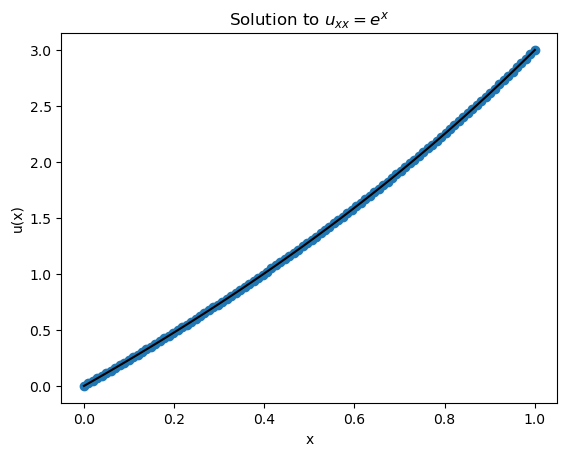

In [ ]:
# Descretization
m = 100
x_bc = np.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)


# Solve system using FD2
U_FD = FD2(a, b, u_a, u_b, f, m)
epsilon = np.linalg.norm(u_true(x_bc) - U_FD, ord=2)
print(f"FD Error: {epsilon:.2e}")

# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U_FD, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")

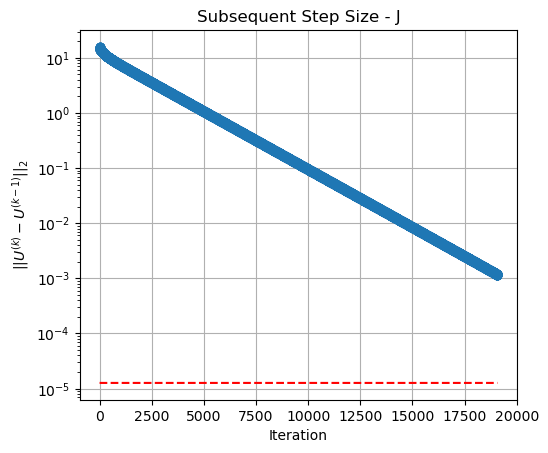

In [ ]:
# Jacobi Method

# Expected iterations needed
iterations_J = int(2.0 * np.log(delta_x) / np.log(1.0 - 0.5 * np.pi**2 * delta_x**2))

# Initial guess for iterations
U_new = np.zeros(m + 2)
U_new[0] = u_a
U_new[-1] = u_b
convergence_J = np.zeros((iterations_J))
for k in range(iterations_J):
    U = U_new.copy()
    for i in range(1, m + 1):
        U_new[i] = 0.5 * (U[i+1] + U[i-1]) - f(x_bc[i]) * delta_x**2 / 2.0

    convergence_J[k] = np.linalg.norm(u_true(x_bc) - U_new, ord=2)
        

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
axes = fig.add_subplot(1, 3, 1)
axes.semilogy(list(range(iterations_J)), convergence_J, 'o')
axes.semilogy(list(range(iterations_J)), np.ones(iterations_J) * epsilon, 'r--')
axes.set_title("Subsequent Step Size - J")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
axes.grid(True) 
plt.show()

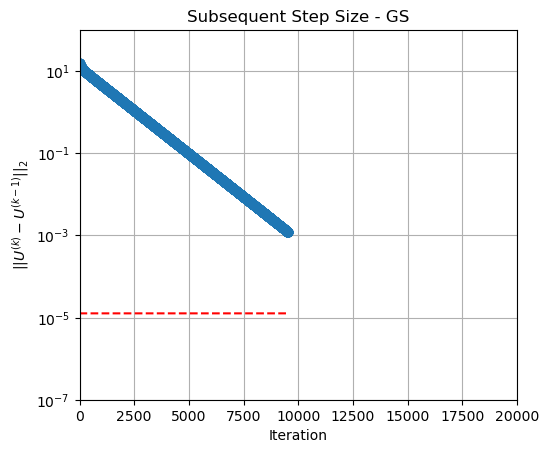

In [ ]:
# Gauss-Seidel Iteration

# Expected iterations needed
iterations_GS = int(2.0 * np.log(delta_x) / np.log(1.0 - np.pi**2 * delta_x**2))

# Initial guess for iterations
U = np.zeros(m + 2)
U[0] = u_a
U[-1] = u_b
convergence_GS = np.zeros((iterations_GS))
for k in range(iterations_GS):
    for i in range(1, m + 1):
        U[i] = 0.5 * (U[i+1] + U[i-1]) - f(x_bc[i]) * delta_x**2 / 2.0

    convergence_GS[k] = np.linalg.norm(u_true(x_bc) - U, ord=2)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
axes = fig.add_subplot(1, 3, 1)
axes.semilogy(list(range(iterations_GS)), convergence_GS, 'o')
axes.semilogy(list(range(iterations_GS)), np.ones(iterations_GS) * epsilon, 'r--')
axes.set_title("Subsequent Step Size - GS")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
axes.set_ylim(1e-7, 1e2)  
axes.set_xlim(0, 2e4)
axes.grid(True) 
plt.show()

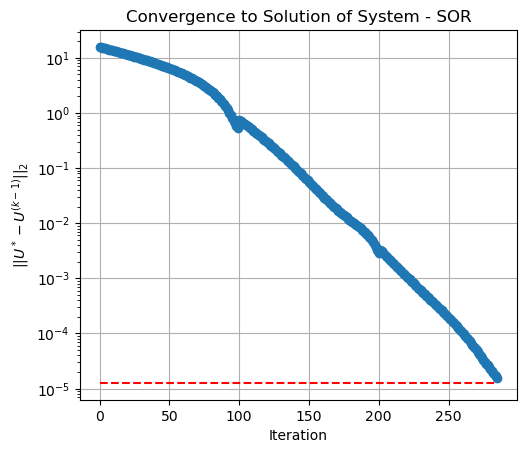

In [ ]:
# SOR parameter
omega = 2.0 / (1.0 + np.sin(np.pi * delta_x))

# Expected iterations needed
iterations_SOR = int(2.0 * np.log(delta_x) / np.log(1.0 - 2.0 * np.pi * delta_x)) * 2

# Initial guess for iterations
U = np.zeros(m + 2)
U[0] = u_a
U[-1] = u_b
convergence_SOR = np.zeros((iterations_SOR))
for k in range(iterations_SOR):
    U_old = U.copy()
    for i in range(1, m + 1):
        U_gs = 0.5 * (U[i-1] + U[i+1] - delta_x**2 * f(x_bc[i]))
        U[i] += omega * (U_gs - U[i])

    convergence_SOR[k] = np.linalg.norm(u_true(x_bc) - U, ord=2)
        
# Plot result
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
axes = fig.add_subplot(1, 3, 1)
axes.semilogy(list(range(iterations_SOR)), convergence_SOR, 'o')
axes.semilogy(list(range(iterations_SOR)), np.ones(iterations_SOR) * epsilon, 'r--')
axes.set_title("Convergence to Solution of System - SOR")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^* - U^{(k-1)}||_2$")
axes.grid(True)  
plt.show()


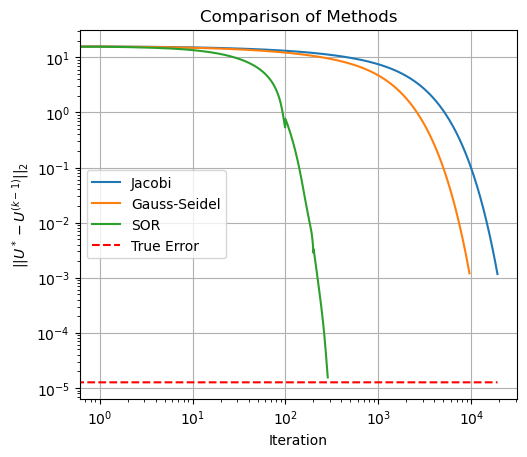

In [ ]:
# Plot result
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
axes = fig.add_subplot(1, 3, 1)
axes.loglog(list(range(iterations_J)), convergence_J)
axes.loglog(list(range(iterations_GS)), convergence_GS)
axes.loglog(list(range(iterations_SOR)), convergence_SOR)
axes.loglog(list(range(iterations_J)), np.ones(iterations_J) * epsilon, 'r--')
axes.set_title("Comparison of Methods")
axes.legend(["Jacobi", "Gauss-Seidel", "SOR", "True Error"])
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^* - U^{(k-1)}||_2$")
axes.grid(True) 
plt.show()

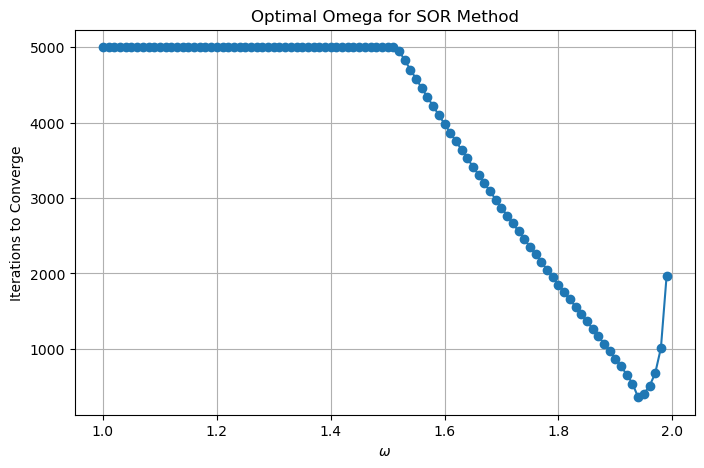

Optimal omega: 1.9400 with 359 iterations


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: np.exp(x)
u_true = lambda x: (4.0 - np.exp(1.0)) * x - 1.0 + np.exp(x)

# Discretization
m = 100
x_bc = np.linspace(a, b, m + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (m + 1)

# Convergence criterion
epsilon = 1e-8
max_iterations = 5000

# Range of omega values to test
omega_values = np.linspace(1.0, 1.99, 100)
iterations_needed = []

for omega in omega_values:
    # Initial guess
    U = np.zeros(m + 2)
    U[0] = u_a
    U[-1] = u_b
    
    for k in range(max_iterations):
        U_old = U.copy()
        for i in range(1, m + 1):
            U_gs = 0.5 * (U[i-1] + U[i+1] - delta_x**2 * f(x_bc[i]))
            U[i] += omega * (U_gs - U[i])
        
        # Check convergence
        if np.linalg.norm(U - U_old, ord=2) < epsilon:
            iterations_needed.append(k + 1)
            break
    else:
        iterations_needed.append(max_iterations)

# Plot iterations vs omega
plt.figure(figsize=(8,5))
plt.plot(omega_values, iterations_needed, 'o-')
plt.xlabel(r'$\omega$')
plt.ylabel('Iterations to Converge')
plt.title('Optimal Omega for SOR Method')
plt.grid(True)
plt.show()

# Print best omega
best_idx = np.argmin(iterations_needed)
print(f"Optimal omega: {omega_values[best_idx]:.4f} with {iterations_needed[best_idx]} iterations")


## Convergence of Iterative Methods


To analyze these methods, consider the update formula

$$
\boldsymbol{x}^{[k+1]} = M^{-1} N \boldsymbol{x}^{[k]} + M^{-1} \boldsymbol{b} \equiv G \boldsymbol{x}^{[k]} + \boldsymbol{c},
$$

where

$$
G = M^{-1} N \quad \text{and} \quad \boldsymbol{c} = M^{-1} \boldsymbol{b}.
$$

Let $\boldsymbol{U}^*$ represent the true solution to the system $A\boldsymbol{U} = \boldsymbol{F}$. Then,

$$
\boldsymbol{U}^* = G \boldsymbol{U}^* + \boldsymbol{c},
$$

showing that the true solution is a fixed point, or equilibrium, of the iteration (however, it is not yet clear that we would converge toward $\boldsymbol{U}^*$ for any initial guess).

Let the error be

$$
\boldsymbol{e}^{[k]} = \boldsymbol{U}^{[k]} - \boldsymbol{U}^*.
$$

Then the error propagates as

$$
\boldsymbol{e}^{[k+1]} = G \boldsymbol{e}^{[k]},
$$

and after $k$ steps

$$
\boldsymbol{e}^{[k]} = G^k \boldsymbol{e}^{[0]}.
$$

Therefore, the method will converge for any initial guess $\boldsymbol{U}^{[0]}$ provided

$$
G^k \to 0 \quad \text{as} \quad k \to \infty.
$$

Assuming that $G$ is diagonalizable, we can write

$$
G = R \Lambda R^{-1},
$$

where $R$ is the matrix of right eigenvectors of $G$ and $\Lambda$ is a diagonal matrix of eigenvalues $\lambda_1, \dots, \lambda_m$. Then

$$
G^k = R \Lambda^k R^{-1},
$$

where

$$
\Lambda^k = 
\begin{bmatrix}
\lambda_1^k &   &        &      \\
  &  \lambda_2^k &       &     \\
  &              & \ddots &     \\ 
  &              &       & \lambda_m^k
\end{bmatrix}
$$

Therefore, the method converges if

$$
|\lambda_j| < 1 \quad \text{for all } j = 1,2,\dots,m,
$$

i.e., if the spectral radius

$$
\rho(G) = \max |\lambda_j| < 1.
$$


### Rate of Convergence

To determine how rapidly the method is expected to converge, we can use the 2-norm, leading to

$$
||\boldsymbol{e}^{[k]}||_2 \le ||R||_2 , ||\Lambda^k||_2 , ||R^{-1}||_2 , ||\boldsymbol{e}^{[0]}||_2.
$$

If the matrix $G$ is normal, then the eigenvectors are orthogonal, and

$$
||R||_2 , ||R^{-1}||_2 = 1.
$$

As a result,

$$
||\boldsymbol{e}^{[k]}||_2 \le (\rho(G))^k , ||\boldsymbol{e}^{[0]}||_2,
$$

where $\rho(G)$ is the spectral radius of $G$.



### Iterative Methods in Matrix Form

To discuss the convergence of the Jacobi, Gauss–Seidel, and SOR($\omega$) methods, we write the iterative methods in matrix form. Given a linear system

$$
A \boldsymbol{x} = \boldsymbol{b},
$$

let $D$ denote the diagonal matrix of $A$, $-L$ the lower triangular part, and $-U$ the upper triangular part. The iteration matrices for the three basic methods are:

* **Jacobi method:**
  $$
  G = D^{-1} (L + U), \quad \boldsymbol{c} = D^{-1} \boldsymbol{b}
  $$

* **Gauss–Seidel method:**
  $$
  G = (D - L)^{-1} U, \quad \boldsymbol{c} = (D - L)^{-1} \boldsymbol{b}
  $$

* **SOR($\omega$) method:**
  $$
  G = (I - \omega D^{-1} L)^{-1} \big((1 - \omega) I + \omega D^{-1} U \big), \quad
  \boldsymbol{c} = \omega (I - \omega L)^{-1} D^{-1} \boldsymbol{b}
  $$



### Example: The Jacobi Method

For the Jacobi method:

$$
G = D^{-1}(L + U) = D^{-1}(D - A) = I - D^{-1} A.
$$

Applied to the 1D BVP $u'' = f$:

$$
G = I + \frac{h^2}{2} A.
$$

The eigenvectors of $G$ are the same as those of $A$, and the eigenvalues are

$$
\gamma_p = 1 + \frac{h^2}{2} \lambda_p,
$$

where

$$
\lambda_p = \frac{2}{h^2} \big[\cos(p \pi h) - 1 \big].
$$

Hence

$$
\gamma_p = \cos(p \pi h), \quad p = 1,2,\dots,m,
$$

and the spectral radius is

$$
\rho(G) = |\gamma_1| = \cos(\pi h) \approx 1 - \frac{1}{2} \pi^2 h^2 + O(h^4).
$$

Since $\rho(G) < 1$ for any $h>0$, the Jacobi method converges.


#### Number of Iterations

Suppose we want to reduce the error to

$$
||\boldsymbol{e}^{[k]}|| \approx \epsilon , ||\boldsymbol{e}^{[0]}||, \quad (||\boldsymbol{e}^{[0]}|| \sim O(1)).
$$

Then

$$
\rho^k \approx \epsilon, \quad \text{so} \quad k \approx \frac{\log(\epsilon)}{\log(\rho)}.
$$

Choosing $\epsilon$ related to the expected global error, $\epsilon = C h^2$, gives

$$
k \approx \frac{\log(C) + 2 \log(h)}{\log(\rho)}.
$$

With $\rho(G) \approx 1 - \frac{1}{2} \pi^2 h^2$ and $h = 1/(m+1)$, we get

$$
k = O(m^2 \log m), \quad \text{as } m \to \infty.
$$

Each iteration requires $O(m)$ work in 1D ($O(m^2)$ in 2D, $O(m^3)$ in 3D), so the total work is $O(m^3 \log m)$. Gaussian elimination solves this tridiagonal problem in $O(m)$ work, so iterative methods are less efficient in this case.





## Some Comments


* The matrix $A$ is never stored. Actually, none of the $5m^2$ FD coefficients with values $1/h^2$ or $4/h^2$ are stored, only the values $0.25$ and $h^2$. 

* The storage is optimal: only the $m^2$ solution values are stored in the Gauss--Seidel method. For the Jacobi iteration, the storage is $2m^2$ since `unew` and `u` are required to be stored. 

* Each iteration requires $O(m^2)$ work. 
%The total work required depends on how many iterations are required to reach the desired level of accuracy. 
We will see that $O(m^2 \log m)$ iterations are required to reach a level of
accuracy consistent with the expected global error in the solution (as $h\to0$ we should require more accuracy in the solution to the linear system). Combining this with the work per iteration gives a total operation count of $O(m^4 \log m)$. 

* This looks worse than Gaussian elimination!!! However, since $\log m$ grows
so slowly with $m$ it is not clear which is really more expensive for a realistic-size
matrix. And the iterative method definitely saves on storage.

* Modern iterative methods that are much more effective for large-scale problems typically require $O(m^2)$ work per iteration, and the number of iterations is independent of $h$. As a result, less computational work is required and converge is achieved much faster. Some of these ``modern'' methods are preconditioned conjugate-gradient (CG) methods, Krylov space methods such as generalized minimum residual (GMRES), and multigrid methods.



## Exercises

--- 

### Exercise 1

The file `iter_bvp_Asplit.py` implements the Jacobi, Gauss-Seidel, and SOR matrix splitting methods for the 1D boundary value problem

$$
u''(x) = f(x), \quad a \le x \le b, \quad u(a) = \alpha, , u(b) = \beta.
$$

In Python, students are asked to implement and test these methods.

#### Tasks

(a) Run the program for each method and produce a plot of error vs. number of iterations.

(b) The convergence of SOR is very sensitive to the relaxation parameter $\omega$. Try $\omega = 1.8$ or $1.95$ and observe the effect.

(c) Let

$$
g(\omega) = \rho(G(\omega))
$$

be the spectral radius of the iteration matrix $G$ for a given $\omega$. Write a program to plot $g(\omega)$ for $0 < \omega \le 2$.

(d) Do **not** implement SOR as

```python
for iter in range(maxiter):
    uGS = np.linalg.solve(DA - LA, UA @ u + rhs)
    u = u + omega * (uGS - u)
```

Explain why this does not work and implement the correct line-by-line SOR update.

---

#### Python Skeleton (`iter_bvp_Asplit.py`)

```python
import numpy as np
import matplotlib.pyplot as plt

def jacobi(u, f, h, maxiter):
    """Jacobi iteration for u'' = f on 1D grid."""
    m = len(u) - 2
    unew = u.copy()
    for k in range(maxiter):
        for i in range(1, m+1):
            unew[i] = 0.5*(u[i-1] + u[i+1] - h**2 * f[i])
        u[:] = unew[:]
    return u

def gauss_seidel(u, f, h, maxiter):
    """Gauss-Seidel iteration for u'' = f on 1D grid."""
    m = len(u) - 2
    for k in range(maxiter):
        for i in range(1, m+1):
            u[i] = 0.5*(u[i-1] + u[i+1] - h**2 * f[i])
    return u

def sor(u, f, h, omega, maxiter):
    """Successive Overrelaxation (SOR) iteration for u'' = f."""
    m = len(u) - 2
    for k in range(maxiter):
        for i in range(1, m+1):
            u_new = 0.5*(u[i-1] + u[i+1] - h**2 * f[i])
            u[i] = u[i] + omega*(u_new - u[i])
    return u

# === Example usage ===
if __name__ == "__main__":
    m = 50
    x = np.linspace(0, 1, m+2)
    h = x[1] - x[0]
    f = np.ones_like(x)  # Example RHS
    u0 = np.zeros_like(x)
    u0[0], u0[-1] = 0, 0  # Boundary conditions

    u_jacobi = jacobi(u0.copy(), f, h, maxiter=100)
    u_gs = gauss_seidel(u0.copy(), f, h, maxiter=100)
    u_sor = sor(u0.copy(), f, h, omega=1.5, maxiter=100)
```

Students should complete the plotting, error computation, and SOR spectral radius analysis.

---

### Exercise 2

Solve the 2D Poisson problem

$$
\nabla^2 u(x,y) = f(x,y), \quad (x,y) \in [-1,1]\times[-1,1], \quad u|_{\partial \Omega} = g(x,y),
$$

with exact solution

$$
u(x,y) = e^x \sin(\pi y)
$$

using the 5-point finite difference stencil. Set $m=n=39$ ($h=1/20$), and tolerance $10^{-5}$. Implement Jacobi, Gauss-Seidel, and SOR in Python. Plot iteration count vs method and study effect of $\omega$ on SOR convergence.

Optimal relaxation parameter:

$$
\omega^* = \frac{2}{1 + \sin(\pi h)} \approx 1.8545.
$$

---

### Exercise 3

Implement and compare Jacobi, Gauss-Seidel, and SOR methods for the general elliptic PDE

$$
u_{xx} + p(x,y) u_{yy} + r(x,y) u(x,y) = f(x,y), \quad a < x < b, \quad c < y < d
$$

with boundary conditions

$$
u(a,y) = 0, \quad u(x,c) = 0, \quad u(x,d) = 0, \quad \frac{\partial u}{\partial x}(b,y) = -\pi \sin(\pi y).
$$

Test the case

$$
p(x,y) = 1 + x^2 + y^2, \quad r(x,y) = -xy, \quad u(x,y) = \sin(\pi x) \sin(\pi y)
$$

and perform a grid refinement study with $m+1 = 8,16,32,64,\dots$ using infinity norm and tolerance $10^{-8}$. Compare number of iterations for each method with optimal $\omega$.

---